In [3]:
import os
import re
import matplotlib.pyplot as plt
import matplotlib.tri as tri
from sklearn import preprocessing
from sklearn.manifold import TSNE
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import numpy as np
import matplotlib
import torch
import torch.nn as nn
import torch.nn.functional as F

## Data

In [151]:
# path = "/content/drive/MyDrive/ML_data.json"
path = "data/band/ML_data.json"
repr_path = "mdl_data/representations_e"
df = pd.read_json(path)

# read structure representations
available = sorted(os.listdir(repr_path))
lookup = dict()
for idx, fn in enumerate(available):
    pmg_id = int(fn.split('_')[1])
    lookup[pmg_id] = idx
    
def load_from_id(pmg_id):
    try:
        fn = available[lookup[pmg_id]]
    except KeyError:
        #print(f"Missing representation vector for pymatgen ID: {pmg_id}")
        return float('nan')
    reprpath = os.path.join(repr_path, fn)
    return torch.load(reprpath)

In [152]:
df['pmg_ids'] = df['filename'].apply(lambda x: int(re.findall(r'\d+', x)[0]))
df['struct_feat'] = df['pmg_ids'].apply(load_from_id)

# limit to conduction band (500:600)
start=500
end=600
df['PBE'] = df['PBE'].apply(lambda x: x[start:end])
df['HSE'] = df['HSE'].apply(lambda x: x[start:end])

df = df.dropna()

In [154]:
X_data = np.vstack(df['PBE'].values)
struct_data = torch.vstack(tuple(df['struct_feat'].values))
y_data = np.vstack(df['HSE'].values)
tsne = TSNE(perplexity=40)
struct_tsne = tsne.fit_transform(np.vstack(df['struct_feat'].apply(lambda x: x.detach().cpu().numpy()).values))

In [ ]:
plt.scatter(struct_tsne[:,0], struct_tsne[:,1], s=2)
plt.show()

In [155]:
X_train, X_test, struct_train, struct_test, tsne_train, tsne_test, y_train, y_test = train_test_split(X_data, struct_data, struct_tsne, y_data, test_size=0.1, shuffle=True)
X_train, X_val, struct_train, struct_val, tsne_train, tsne_val, y_train, y_val = train_test_split(X_train, struct_train, tsne_train, y_train, test_size=0.11, shuffle=True)

In [156]:
# Generate dataset 
class BandstructureDataset(Dataset):
    def __init__(self, X, struct, tsne, y):
        self.X = torch.Tensor(X)  # store X as a pytorch Tensor
        self.struct = torch.Tensor(struct) # store structure as pytorch Tensor
        self.tsne = tsne
        self.y = torch.Tensor(y) # store Y as a pytorch Tensor
        self.len=len(self.X)                # number of samples in the data 

    def __getitem__(self, index):
        return self.X[index], self.struct[index], self.tsne[index], self.y[index] # get the appropriate item

    def __len__(self):
        return self.len

In [157]:
train_data = BandstructureDataset(X_train, struct_train, tsne_train, y_train)# fill in arguments
val_data = BandstructureDataset(X_val, struct_val, tsne_val, y_val)# fill in arguments
test_data = BandstructureDataset(X_test, struct_test, tsne_test, y_test)# fill in arguments

batch_size = 64 # fill in batch size
train_dataloader = DataLoader(train_data, batch_size=batch_size, shuffle=True)# fill in shuffle argument
val_dataloader = DataLoader(val_data, batch_size=batch_size, shuffle=True)# fill in shuffle argument
test_dataloader = DataLoader(test_data, batch_size=batch_size, shuffle=True)# fill in shuffle argument

print(X_train.shape)
print(X_val.shape)
print(X_test.shape)

(3099, 100)
(384, 100)
(387, 100)


## Model Architecture

In [167]:
class BandstructureCNN(torch.nn.Module):
    def __init__(self, convlayers=3, channels=128, kernelsize=8, iosize=100, reprsize=100):
        super().__init__()
        self.n_conv = convlayers
        self.inputsize = iosize
        self.conv1 = nn.Conv1d(1, channels, kernel_size=kernelsize)
        self.bn = nn.BatchNorm1d(channels)
        
        self.convs = nn.ModuleList([nn.Conv1d(channels, channels, kernel_size=kernelsize) for i in range(convlayers-1)])

        self.fc1 = nn.Linear((self.inputsize - self.n_conv*(kernelsize - 1)) * channels + reprsize, self.inputsize * 2)
        self.fc2 = nn.Linear(self.inputsize * 2, self.inputsize)
        self.fc3 = nn.Linear(self.inputsize * 2, self.inputsize)
        
    def forward(self, x, representation):
        # Apply convolutions
        x1 = F.relu(self.bn(self.conv1(x)))
        for conv in self.convs:
            x1 = F.relu(self.bn(conv(x1)))
        # Apply MLP
        x2 = torch.concat((torch.flatten(x1, 1, 2), representation), axis=1) # concat repr
        x3 = F.leaky_relu(self.fc1(x2))
        x4 = torch.concat((F.leaky_relu(self.fc2(x3)), x.squeeze()), axis=1) # residual connection
        x5 = self.fc3(x4)
        return x5

device = 'cuda'
model = BandstructureCNN().to(device)
for batch in train_dataloader:
    X, struct, Y = batch
    X = X.to(device)[:,500:600].unsqueeze(1)
    out = model(X, struct)
    print(out.shape)
    break

In [168]:
def train(model, dataloader, optimizer, device):
    
    '''
    A function train on the entire dataset for one epoch .
    
    Args: 
        model (torch.nn.Module): your model from before 
        dataloader (torch.utils.data.DataLoader): DataLoader object for the train data
        optimizer (torch.optim.Optimizer(()): optimizer object to interface gradient calculation and optimization 
        device (str): Your device (usually 'cuda:0' for your GPU)
        
    Returns: 
        float: loss averaged over all the batches 
    
    '''

    epoch_loss = []
    model.train() # Set model to training mode 
    
    for batch in dataloader:    
        X, struct, tsne, y = batch
        X = X.to(device).unsqueeze(1)
        struct = struct.to(device)
        y = y.to(device).unsqueeze(1)
        
        # train your model on each batch here 
        y_pred = model(X, struct)
        
        loss = nn.functional.mse_loss(y_pred, y.squeeze(1))
        epoch_loss.append(loss.item())
        
        # run backpropagation given the loss you defined
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    return np.array(epoch_loss).mean()


def validate(model, dataloader, device):
    
    '''
    A function validate on the validation dataset for one epoch .
    
    Args: 
        model (torch.nn.Module): your model for before 
        dataloader (torch.utils.data.DataLoader): DataLoader object for the validation data
        device (str): Your device (usually 'cuda:0' for your GPU)
        
    Returns: 
        float: loss averaged over all the batches 
    
    '''
    
    val_loss = []
    model.eval() # Set model to evaluation mode 
    with torch.no_grad():    
        for batch in dataloader:
            X, struct, tsne, y = batch
            X = X.to(device).unsqueeze(1)
            struct = struct.to(device)
            y = y.to(device).unsqueeze(1)
            
            # validate your model on each batch here 
            y_pred = model(X, struct)

            loss = nn.functional.mse_loss(y_pred, y.squeeze(1))
            val_loss.append(loss.item())
            
    return np.array(val_loss).mean()


## Training and Evaluation

In [169]:
# device to train on
device = 'cuda:0'
# define your model
#model = BandstructureCNN(convlayers=1, channels=256, kernelsize=3, reprsize=300).to(device) # hyperopt's choice
model = BandstructureCNN(reprsize=300).to(device)

# define your optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', factor=0.8, patience=50, verbose=True)

In [170]:
print("epoch", "train loss", "validation loss")

val_loss_curve = []
train_loss_curve = []

for epoch in range(800):
    
    # Compute train your model on training data
    epoch_loss = train(model, train_dataloader, optimizer,  device=device)
    
    # Validate your on validation data 
    val_loss = validate(model, val_dataloader, device=device) 
    scheduler.step(val_loss)
    
    # Record train and loss performance 
    train_loss_curve.append(epoch_loss)
    val_loss_curve.append(val_loss)
    
    if epoch % 25 == 0:
        print(epoch, epoch_loss, val_loss)
    
    # save model 
    if epoch % 100 == 0:
        torch.save(model.state_dict(), "{}/cnn_calib_{}.pt".format("cnnmodel_e_single", epoch))

epoch train loss validation loss
0 2.637803495538478 1.6282446483771007
25 0.511204653704653 1.7462617953618367
50 0.3127947055107477 1.343582808971405
75 0.2404461993398715 0.9952696065107981
100 0.2272916454821825 1.1353610555330913
125 0.1891965054887898 0.9380185467501482
150 0.2790460785736843 1.1171633029977481
175 0.15605423610885533 0.9577020034193993
Epoch 00178: reducing learning rate of group 0 to 5.0000e-04.
200 0.1240526909882925 0.9371496066451073
225 0.12230282024081264 0.9788909927010536
Epoch 00251: reducing learning rate of group 0 to 2.5000e-04.
250 0.09323172782528766 1.4561710755030315
275 0.04941994077240934 1.6201854646205902
300 0.043617625207621226 1.893216001490752
Epoch 00302: reducing learning rate of group 0 to 1.2500e-04.
325 0.046715087703980356 1.9410663495461147
350 0.03526009040485535 1.5459482620159786
Epoch 00353: reducing learning rate of group 0 to 6.2500e-05.
375 0.028848433287396114 1.6004469444354374
400 0.031028957020643413 1.4530165642499924
E

KeyboardInterrupt: 

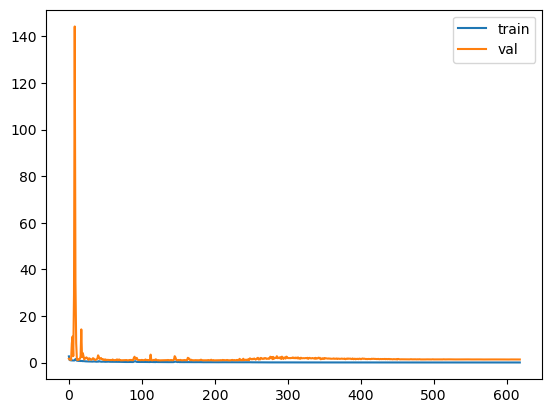

In [171]:
plt.plot(train_loss_curve, label='train')
plt.plot(val_loss_curve, label='val')
plt.legend()
plt.show()

In [181]:
model.load_state_dict(torch.load("cnnmodel_e_single/cnn_calib_300.pt"))

<All keys matched successfully>

In [182]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_absolute_error

model.eval()
Xs = []
y_preds = []
y_trues = []
tsnes = []

with torch.no_grad():    
    for batch in test_dataloader: # probably a more efficient way to do this? not sure
        X, struct, tsne, y = batch
        tsnes.append(tsne)
        Xs.append(X)
        X = X.to(device).unsqueeze(1)
        struct = struct.to(device)
        y = y.to(device).unsqueeze(1)
        y_pred = model(X, struct).detach().cpu().numpy()
        y_true = y.squeeze(1).detach().cpu().numpy()
        y_preds.append(y_pred)
        y_trues.append(y_true)

X = np.concatenate(Xs, axis=0)
y_t = np.concatenate(y_trues, axis=0)
y_p = np.concatenate(y_preds, axis=0)
ts = np.concatenate(tsnes, axis=0)

model_mae = mean_absolute_error(y_t, y_p)
maes = np.clip(np.mean(np.abs(y_p - y_t), axis=1), 0, model_mae) # MAEs per conduction band, 
                                                 # clipped to show samples above average MAE

print("Model:", model_mae)
print("PBE:", mean_absolute_error(y_t, X))

Model: 0.30030385
PBE: 0.16097635


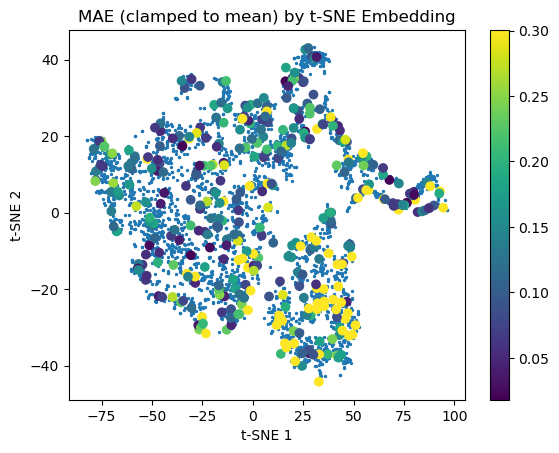

In [186]:
plt.scatter(struct_tsne[:,0], struct_tsne[:,1], s=2)
plt.scatter(ts[:,0], ts[:,1], c=maes)
plt.xlabel("t-SNE 1")
plt.ylabel("t-SNE 2")
plt.colorbar()
plt.title("MAE (clamped to mean) by t-SNE Embedding")
plt.savefig("MAEtSNE.png", dpi=150)
plt.show()

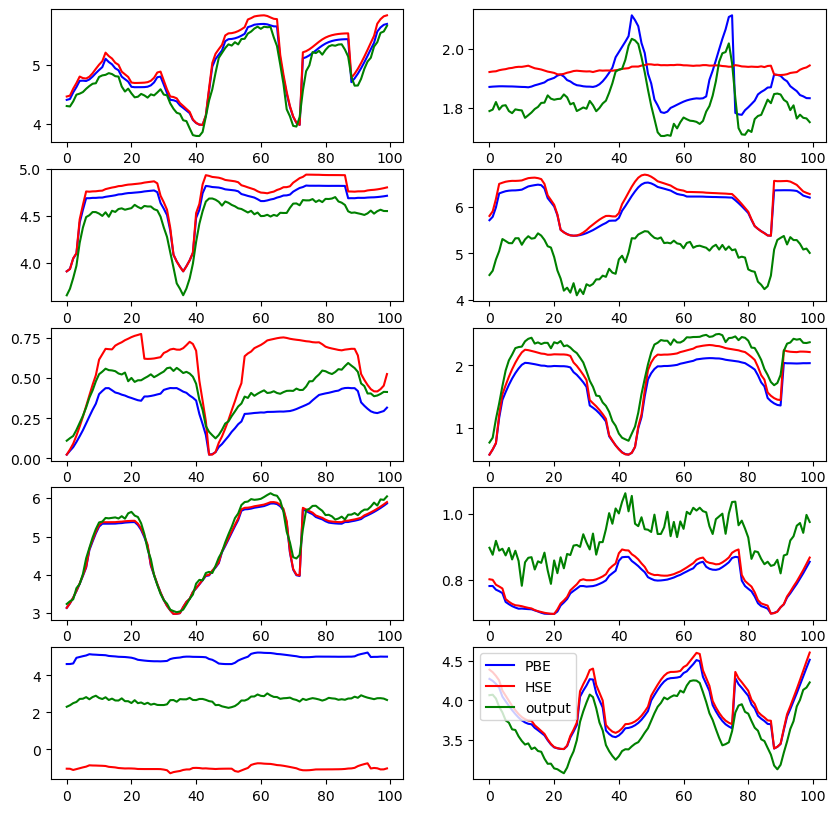

In [49]:
fig, axes = plt.subplots(5,2, figsize=(10,10))
offset=60
for index in range(10):
    X_band = X[index+offset].squeeze()
    y_true_band = y_t[index+offset]
    y_pred_band = y_p[index+offset]
    axes[index%5][index//5].plot(X_band,'b-',label='PBE')
    axes[index%5][index//5].plot(y_true_band, 'r-',label='HSE')
    axes[index%5][index//5].plot(y_pred_band,'g-',label='output')
plt.legend()
plt.show()